## Import

In [1]:
import sys

sys.path.append('C:\\Users\\Marco\\Documents\\GitHub\\GeoSpatial-analysis\\modules')

In [2]:
import json
import pytz
import geojson
import numpy as np
import pandas as pd
import pymongo as pm
import seaborn as sns
import shapely as shp
import geopandas as gpd
from dateutil import parser
from datetime import datetime
from matplotlib import pyplot as plt
from pymongo_get_database import get_database
from convert_geometry import toMultiLineString, toExtremePoints

## Retrieve DB and collections

In [3]:
day = "20_04_2023"

In [4]:
# retrieve database and collections
db_name = "bergenTrafficFlowData"
db = get_database(db_name)

collection_name = "clean_data_" + day
collection_clean = db[collection_name]

## Distribution analysis

In [5]:
df = pd.json_normalize(collection_clean.find({}))
df.set_index("_id", inplace=True)

In [6]:
df['geometry.multi_line'] = df.apply(lambda x: toMultiLineString(x["geometry.geometries"]), axis=1)
df['geometry.extreme_point'] = df.apply(lambda x: toExtremePoints(x["geometry.multi_line"]), axis=1)
df['api_call_time'] = df.apply(lambda x: pd.Timestamp.tz_convert(x["api_call_time"].tz_localize('UTC'), pytz.timezone("Europe/Oslo")), axis=1)
df['sourceUpdated'] = df.apply(lambda x: x["sourceUpdated"].tz_localize('UTC'), axis=1)

In [7]:
gdf = gpd.GeoDataFrame(df, geometry="geometry.multi_line")

### Speed distribution of eanch road segment over time

In [8]:
col = ['api_call_time', 'currentFlow.speedUncapped']

In [9]:
agg_gdf = gdf.groupby(['description','geometry.multi_line'], sort=False)[col].agg(lambda x: list(x))

In [10]:
first_morning_date = datetime.strptime(f"2023-04-{day[:2]}T07:30:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")
last_morning_date = datetime.strptime(f"2023-04-{day[:2]}T09:30:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")

first_midday_date = datetime.strptime(f"2023-04-{day[:2]}T11:00:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")
last_midday_date = datetime.strptime(f"2023-04-{day[:2]}T12:00:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")

first_afternoon_date = datetime.strptime(f"2023-04-{day[:2]}T15:00:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")
last_afternoon_date = datetime.strptime(f"2023-04-{day[:2]}T17:00:00.000+02:00", "%Y-%m-%dT%H:%M:%S.%f%z")

### Utils

In [11]:
def mma_split(agg_gdf, i):
    df = pd.DataFrame([agg_gdf.iloc[i]['api_call_time'], agg_gdf.iloc[i]['currentFlow.speedUncapped']]).T
    df.columns = ['api_call_time', 'currentFlow.speedUncapped']
    df.set_index('api_call_time', inplace=True)
        
    df_morning = df.loc[first_morning_date:last_morning_date]
    df_midday = df.loc[first_midday_date:last_midday_date]
    df_afternoon = df.loc[first_afternoon_date:last_afternoon_date]
    
    return df_morning,df_midday,df_afternoon

In [12]:
def time_series_auto_corr(agg_gdf, i, lag):
    df_morning, df_midday, df_afternoon = mma_split(agg_gdf, i)
    
    morning_auto_corr = pd.Series(list(df_morning['currentFlow.speedUncapped'])).autocorr(lag)
    midday_auto_corr = pd.Series(list(df_midday['currentFlow.speedUncapped'])).autocorr(lag)
    afternoon_auto_corr = pd.Series(list(df_afternoon['currentFlow.speedUncapped'])).autocorr(lag)
    
    print(f"Description: {agg_gdf.index[i][0]}",
          f"Morning auto-correlation: {morning_auto_corr}", 
          f"Midday auto-correlation: {midday_auto_corr}", 
          f"Afternoon auto-correlation: {afternoon_auto_corr}", sep="\n")
    
    #return morning_auto_corr, midday_auto_corr, afternoon_auto_corr

In [13]:
def time_serie_plot(agg_gdf, i, ax):
    df_morning, df_midday, df_afternoon = mma_split(agg_gdf, i)
        
    df_morning.plot(title=agg_gdf.index[i][0], ax=ax, label='morning')
    df_midday.plot(ax=ax, label='midday')
    df_afternoon.plot(ax=ax, label='afternoon')

def time_series_plot(agg_gdf, i, fig_size=(8,5)):
    if type(i) == int:
        fig, ax = plt.subplots(figsize=fig_size)
        time_serie_plot(agg_gdf, i, ax)
        
    elif type(i) == list:
        fig, axs = plt.subplots(figsize=fig_size, nrows=2, ncols=len(i)//2+len(i)%2)
        for j in range(len(i)):
            if len(i) == 2:
                time_serie_plot(agg_gdf, i[j], axs[j])
            else:
                time_serie_plot(agg_gdf, i[j], axs[j//int(len(i)/2)][j%int(len(i)/2)])
        

#### Autocorrelation

In [14]:
for i in range(len(agg_gdf)):
    try:
        time_series_auto_corr(agg_gdf, i, 1)
    except:
        pass
    
    print("\n")

Description: Christies gate
Morning auto-correlation: 0.36961672977254423
Midday auto-correlation: 0.363610331394057
Afternoon auto-correlation: 0.4676203282504877


Description: Åstveitskogen
Morning auto-correlation: 0.544178351672783
Midday auto-correlation: 0.805666958737362
Afternoon auto-correlation: 0.4790743727940264


Description: Nyborg
Morning auto-correlation: 0.3790403423534335
Midday auto-correlation: -0.23595810944685944
Afternoon auto-correlation: 0.5764346132926151


Description: Sandviken bomstasjon
Morning auto-correlation: 0.5477328953882777
Midday auto-correlation: 0.06149924177407421
Afternoon auto-correlation: 0.6426552068370739


Description: Øyjord
Morning auto-correlation: 0.43896476604753476
Midday auto-correlation: 0.3807751586180551
Afternoon auto-correlation: 0.35636389224997467


Description: Øyjord
Morning auto-correlation: 0.8495227836647431
Midday auto-correlation: 0.2826664628187942
Afternoon auto-correlation: 0.4384598331592249


Description: Fisketo

#### Plot

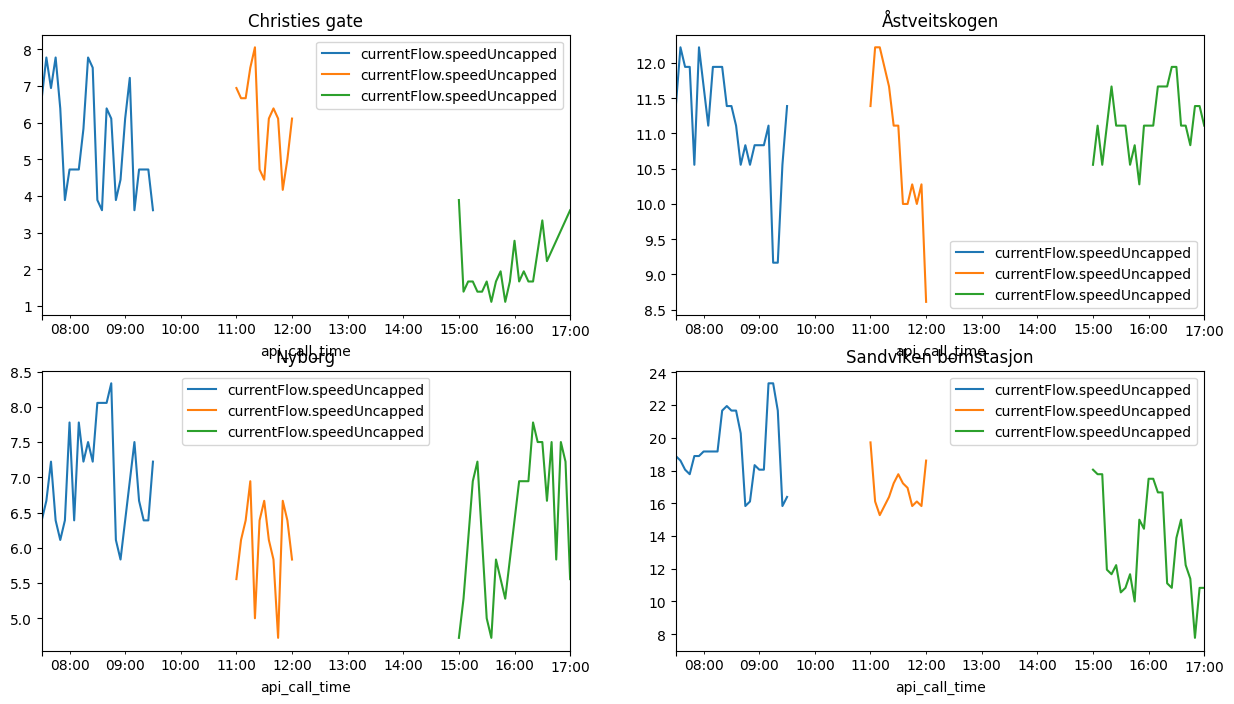

In [15]:
time_series_plot(agg_gdf, list(range(0,4)), (15,8))